# Elements logiciels pour le traitement des données en grande dimension

In [1]:
%matplotlib inline

## Installation de pyspark

In [2]:
import findspark
sparkHome = "C:\Dev\Spark\spark-2.2.0-bin-hadoop2.7"
findspark.init(sparkHome)

### Petit essai pour calculer PI

In [3]:
def printSpendTime (startTime) :
    spendTime = time.time() - startTime
    m, s = divmod(spendTime, 60)
    h, m = divmod(m, 60)
    print("--------------------------------------------------")
    print ("-----   Temps écoulé : %dh%02dm%02ds" % (h, m, s))
    print("--------------------------------------------------")
    return

In [4]:
'''
import pyspark
import random
import time

startTime = time.time()

sc = pyspark.SparkContext(appName="Pi")
num_samples = 100000000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / num_samples
print(pi)

sc.stop()

printSpendTime(startTime)
'''

'\nimport pyspark\nimport random\nimport time\n\nstartTime = time.time()\n\nsc = pyspark.SparkContext(appName="Pi")\nnum_samples = 100000000\n\ndef inside(p):     \n  x, y = random.random(), random.random()\n  return x*x + y*y < 1\n\ncount = sc.parallelize(range(0, num_samples)).filter(inside).count()\n\npi = 4 * count / num_samples\nprint(pi)\n\nsc.stop()\n\nprintSpendTime(startTime)\n'

## Arbre k-d classique

### Création d'un jeu de données

In [5]:
import numpy as np
import pandas

n = 10
data = pandas.DataFrame(np.random.rand(n,2)*100,  columns = ['X', 'Y'])
data.iloc[0:10, ]

,X,Y
0,89.038706,46.196190
1,16.545065,66.311958
2,45.096629,10.323445
3,92.770771,76.878323
4,91.066285,85.094537
5,20.689576,72.471237
6,70.256943,90.361817
7,48.993429,14.122695
8,71.174836,2.799704
9,11.897315,59.731205


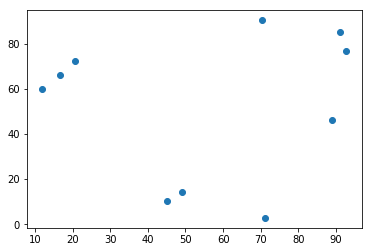

In [6]:
import matplotlib.pyplot as plt

plt.plot(data[['X']], data[['Y']], 'o')
plt.show()

### Définition d'une structure de données pour les arbres binaires

In [7]:
### Classe permettant de definir un arbre binaire simple
### Il se constitue d'un noeud racine, de deux sous-arbres
### et des donnees correspondant au noeud racine
class Tree(object) :
    
    ## Constructeur simple
    def __init__(self) :
        self.left = None
        self.right = None
        self.key = None
        self.data = None
    
    ## Reprensation de l'arbre sous forme de chaine
    ## de caracteres
    def __str__(self) :
        return self.strRec(0)
    
    ## Represente l'arbre sous forme de chaine de caracteres
    ## de facon recursive
    def strRec(self, depth) :
        line = "-" * 3 * depth
        res = line + str(self.data)
        if self.left :
            res += "\n" + self.left.strRec(depth+1)
        if self.right :
            res += "\n" + self.right.strRec(depth+1)
        return res

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines

### Trace un arbre k-d (classe 'Tree') de facon recursive
def pltTreeRec(ax, tree, keyX, keyY, xLim, yLim) :
    if tree :
        x, y = tree.data[keyX], tree.data[keyY]
        if tree.key == keyX :
            pltTreeRec(ax, tree.left, keyX, keyY, (xLim[0], x), yLim)
            pltTreeRec(ax, tree.right, keyX, keyY, (x, xLim[1]), yLim)
            ax.add_line(lines.Line2D((x, x), yLim, linewidth=0.5, color='red'))
        elif tree.key == keyY :
            pltTreeRec(ax, tree.left, keyX, keyY, xLim, (yLim[0], y))
            pltTreeRec(ax, tree.right, keyX, keyY, xLim, (y, yLim[1]))
            ax.add_line(lines.Line2D(xLim, (y, y), linewidth=0.5, color='red'))
        plt.plot(x, y, 'o', color='#1f77b4')

### Trace un jeu de donnees et l'arbre k-d associe.
### Le parametre 'tree' doit etre une instance de la 
### classe 'Tree'
def plotDataTree(data, tree) :
    colList = data.columns.values.tolist()
    keyX, keyY = colList[0], colList[1]
    ax = plt.axes()
    plt.plot(data[['X']], data[['Y']], 'o', color='#1f77b4')
    xLim, yLim = ax.get_xlim(), ax.get_ylim()
    pltTreeRec(ax, tree, keyX, keyY, xLim, yLim)
    plt.show()

### Algorithme "naïf" pour constituer un arbre k-d

<p>
On propose une première implémentation, "naïve", pour la constitution d'un arbre k-d. Le principe : on découpe de façon cyclique selon les différentes dimension ; à chaque étape on recherche la médiane du tableau (donc une opération de tri) selon la dimension courante ; on lui attache deux sous-arbres correspondants aux valeurs inférieures (resp. supérieures) à la médiane.
</p>
<p>
D'après Bentley, si on est en mesure de trouver la médiane en $O(n)$, la complexité de l'algorithme est en $O(n\log(n))$.
</p>

In [9]:
### Fonction recursive pour constituer un arbre k-d
def arbreKDnaifRec (data, colList, curCol) :
    nCol = len(colList)
    nRow = data.shape[0]
    sortCol = colList[curCol]
    if nRow == 0 :
        return None
    elif nRow == 1 :
        dataNode = data.iloc[0,]
        rootNode = Tree()
        rootNode.key = sortCol
        rootNode.data = dict()
        for col in colList :
            rootNode.data[col] = dataNode[col].item()
        return rootNode
    median = int(nRow / 2)
    if nRow % 2 == 1 :
        median = int((nRow-1) / 2)
    nextCol = (curCol + 1) % nCol
    #if nextCol > nCol :
    #    nextCol = 0
    dataSort = data.sort_values(by=sortCol)
    dataNode = dataSort.iloc[median,]
    rootNode = Tree()
    rootNode.key = sortCol
    rootNode.data = dict()
    for col in colList :
        rootNode.data[col] = dataNode[col].item()
    rootNode.left = arbreKDnaifRec(dataSort.iloc[0:median,], colList, nextCol)
    rootNode.right = arbreKDnaifRec(dataSort.iloc[(median+1):nRow,], colList, nextCol)
    return rootNode

### Fonction englobante permettant la construction d'un arbre k-d
def arbreKDnaif (data) :
    colList = data.columns.values.tolist()
    curCol = 0
    return(arbreKDnaifRec(data, colList, curCol))

{'X': 70.25694298364093, 'Y': 90.3618172062273}
---{'X': 11.897314736656984, 'Y': 59.73120453876859}
------{'X': 48.993428804724296, 'Y': 14.122694585829498}
---------{'X': 45.09662905625584, 'Y': 10.323445079251014}
------{'X': 20.68957614794329, 'Y': 72.47123734793547}
---------{'X': 16.545065013032367, 'Y': 66.31195779080427}
---{'X': 92.77077076137684, 'Y': 76.87832267516454}
------{'X': 89.03870644662969, 'Y': 46.196189749227834}
---------{'X': 71.17483582656867, 'Y': 2.7997037256096924}
------{'X': 91.0662853310571, 'Y': 85.09453652161902}


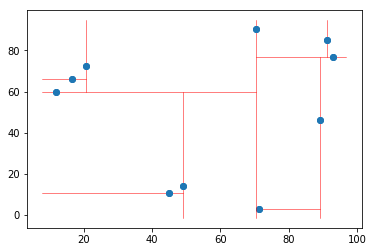

In [10]:
### Test de la fonction 'arbreKDnaif' sur le 
### jeu de donnees 'data'
arbre = arbreKDnaif(data)
print(arbre)
plotDataTree(data, arbre)

### Construction d'un arbre k-d avec pré-tri par dimension

<p>
On implémente, toujours de façon non distribuée, un algorithme de construction d'un arbre k-d où le tri selon les différentes dimension du jeu de données est fait en amont.
</p>

In [11]:
### Fonction recursive pour constituer un arbre k-d
def arbreKDpretriRec (sortedData, colList, curCol) :
    nCol = len(colList)
    sortCol = colList[curCol]
    curData = sortedData[sortCol]
    nRow = curData.shape[0]
    if nRow == 0 :
        return None
    elif nRow == 1 :
        dataNode = curData.iloc[0,]
        rootNode = Tree()
        rootNode.key = sortCol
        rootNode.data = dict()
        for col in colList :
            rootNode.data[col] = dataNode[col].item()
        return rootNode
    median = int(nRow / 2)
    if nRow % 2 == 1 :
        median = int((nRow-1) / 2)
    nextCol = (curCol + 1) % nCol
    dataNode = curData.iloc[median,]
    rootNode = Tree()
    rootNode.key = sortCol
    rootNode.data = dict()
    for col in colList :
        rootNode.data[col] = dataNode[col].item()
    leftSortedData = dict()
    rightSortedData = dict()
    for col in colList :
        if col == sortCol :
            leftSortedData[col] = sortedData[col].iloc[0:median,]
            rightSortedData[col] = sortedData[col].iloc[(median+1):nRow,]
        else :
            ### IL FAUT FINR CETTE PARTIE !!!
            leftSortedData[col] = sortedData[col][sortedData[col][sortCol]]
            rightSortedData[col] = sortedData[col].iloc[(median+1):nRow,]
    rootNode.left = arbreKDpretriRec(leftSortedData, colList, nextCol)
    rootNode.right = arbreKDpretriRec(rightSortedData, colList, nextCol)
    return rootNode

### Fonction englobante permettant la construction d'un arbre k-d
def arbreKDpretri (data) :
    colList = data.columns.values.tolist()
    sortedData = dict()
    for col in colList :
        sortedData[col] = data.sort_values(by = col)
    curCol = 0
    return(arbreKDpretriRec(sortedData, colList, curCol))

In [12]:
### Test de la fonction 'arbreKDnaif' sur le 
### jeu de donnees 'data'
arbre = arbreKDpretri(data)
print(arbre)
plotDataTree(data, arbre)

KeyError: '[ 71.17483583  45.09662906  48.9934288   89.03870645  11.89731474\n  16.54506501  20.68957615  92.77077076  91.06628533  70.25694298] not in index'

In [ ]:
test = dict()
for c in data.columns.values.tolist() :
    test[c] = data.sort_values(by=c)
for k in test.keys() :
    print(k)
    print(test[k])

In [ ]:
data

In [ ]:
data[data["X"] < 50]

In [ ]:
data.columns.values.tolist()[0]